## SÉRIES TEMPORAIS

###APRESENTAÇÃO DE MODELOS
###ALUNOS: ARTUR LUIS e VINÍCIUS VIERI
###MODELOS USADOS: ARIMA, PROPHET e RANDOM FLOREST

Em estatística, econometria, matemática aplicada e processamento de sinais, uma série temporal é uma coleção de observações feitas sequencialmente ao longo do tempo.

A análise será feita em cima dos preços de arroz liso tipo 1. Os dados foram retirados do IPEAdata.

Link de acesso:  http://ipeadata.gov.br/beta3/#/dados-serie?ascOrder=&base=&busca=arroz&columnOrdering=&fonte=&last=0&metaindex=1&serid=DERAL12_ATARPO12&skip=0&tema=&territoriality=



Informações dos dados: 
Preço médio - atacado - arroz (polido tipo 1) - 30 kg - PR.

Frequência: Mensal Fonte: Secretaria da Agricultura e do Abastecimento do 

Estado do Paraná, Departamento de Economia Rural (Seab-PR) 

Unidade: R$ 

Atualizado em: 4/4/2023

Comentário: Os preços das vendas no atacado derivam de um levantamento dos preços pagos pelos varejistas ou industriais junto aos atacadistas, cerealistas, cooperativas e distribuidoras, ponderado pela comercialização regional. Os preços são calculados com base na média mensal paranaense nos últimos 12 meses e médias anuais, ambas médias simples. 

Nota: O Departamento de Economia Rural (Deral), integra a Secretaria de Estado da Agricultura e do Abastecimento (Seab) e é responsável, dentre outras atividades, pela geração de dados, análise e acompanhamento do desenvolvimento de diversas cadeias da produção rural e agrícola de importância para o estado do Paraná, os quais dão suporte à propostas de políticas agrícolas. 


Mais Informações: Departamento de Economia Rural - Deral



#Imports e processamento dos dados

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # importar o teste ADF
import numpy as np

In [ ]:
df = pd.read_excel("rice.xls")

In [ ]:
df = df.drop(['SERCODIGO'], axis=1)

In [ ]:
df

,DIA,MES,ANO,VALVALOR
0,1,1,2000,21.2200
1,1,2,2000,21.3100
2,1,3,2000,21.5600
3,1,4,2000,20.6000
4,1,5,2000,19.9500
...,...,...,...,...
274,1,11,2022,99.3432
275,1,12,2022,109.5028
276,1,1,2023,115.8807
277,1,2,2023,114.7058


In [ ]:
df['date'] = df['ANO'].map(str) + "-" + df['MES'].map(str)

In [ ]:
df = df.set_index(pd.to_datetime(df["date"], format='%Y-%m'))

In [ ]:
df = df.drop(['DIA', 'MES', 'ANO', 'date'], axis=1)

Text(0, 0.5, 'Preço (R$)')

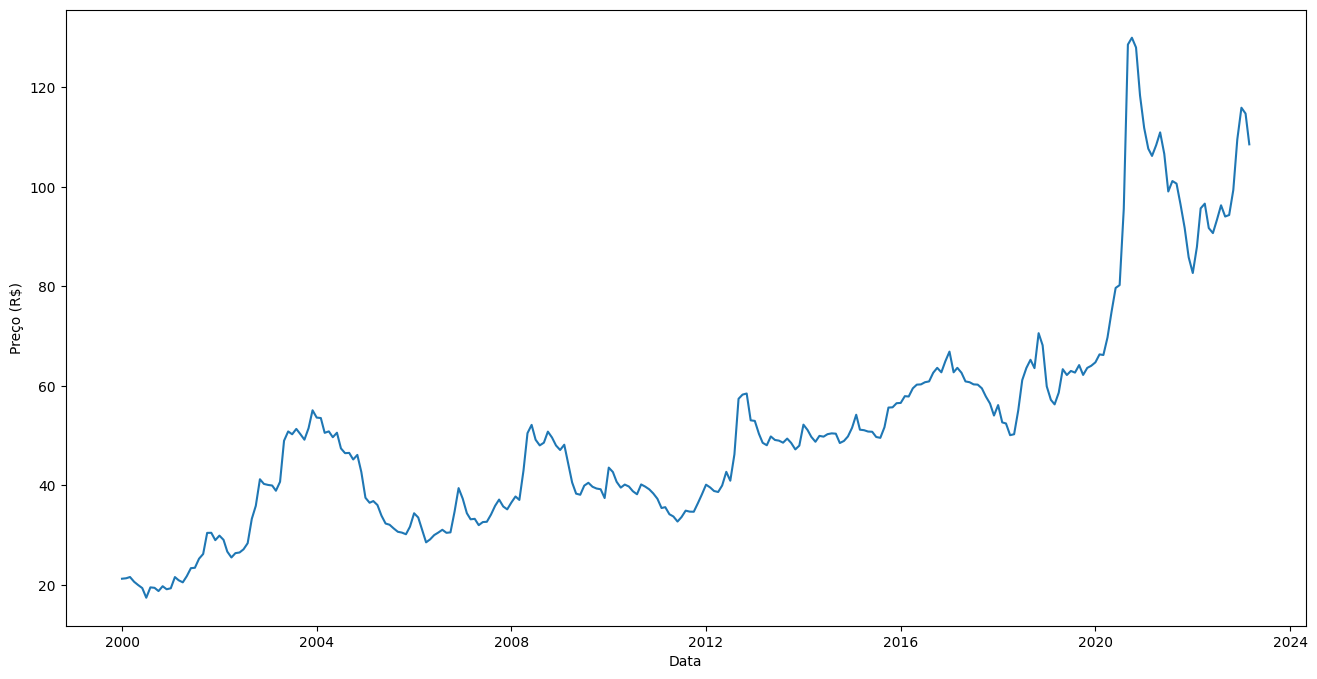

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df.VALVALOR)
plt.xlabel('Data')
plt.ylabel('Preço (R$)')

#Alguns pressupostos

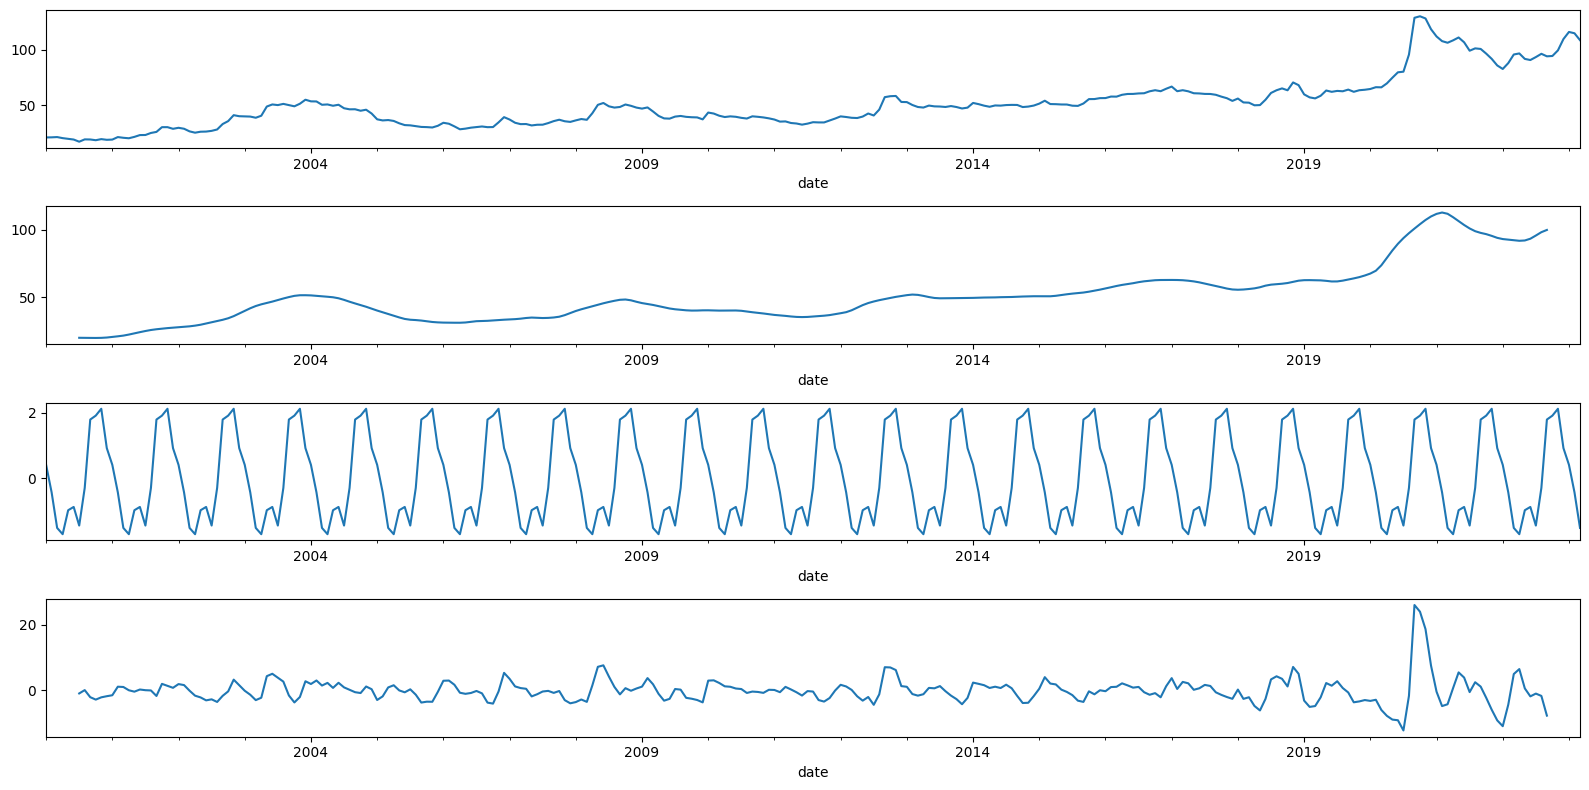

In [ ]:
result = seasonal_decompose(df)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(16,8))
result.observed.plot(ax=ax1) #Própria série temporal
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

In [ ]:
X = df.VALVALOR.values

In [ ]:
# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))  #Testes estatísticos maiores que os valores estatísticos
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -0.8395
Valor-p: 0.8072
Valores Críticos:
	1%: -3.4543
	5%: -2.8721
	10%: -2.5724


#Como vimos, a série não é estacionária, devemos transformá-la

###Transformar a serie não estacionário em não estacionaria
###Para transforma-la em série estacionária precisaremos remover a tendência e a sazonalidade nos dados originais, 
###para isso há vários métodos, mas um bom começo é aplicar o log para eliminar a magnitude dos valores da time series e 
###logo depois subtrair a média móvel de um determinado período em relação ao logaritmo da time series.

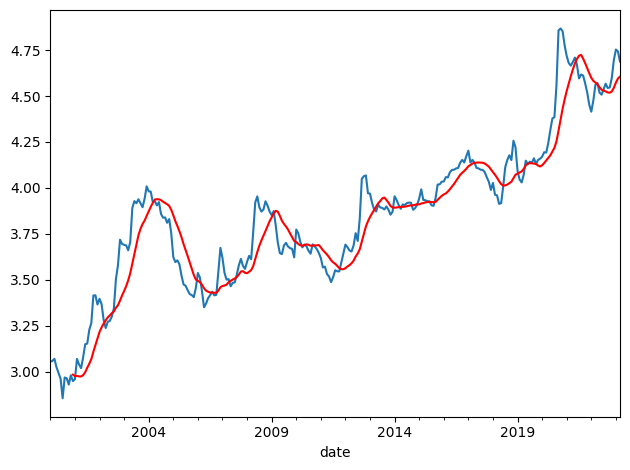

In [ ]:
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

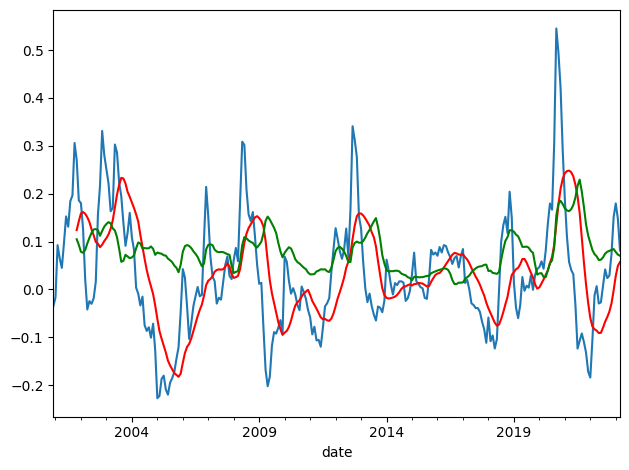

In [ ]:
#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
#desvio padrão
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots()
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, legend=False, color='r')
std_sub.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [ ]:
#repetir o ADF
X_sub = df_sub.VALVALOR.values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -4.4248
Valor-p: 0.0002682313
Valores Críticos:
	1%: -3.4553
	5%: -2.8725
	10%: -2.5726


Dickey-Fuller Aumentado
Teste Estatístico: -11.2652
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4553
	5%: -2.8725
	10%: -2.5726


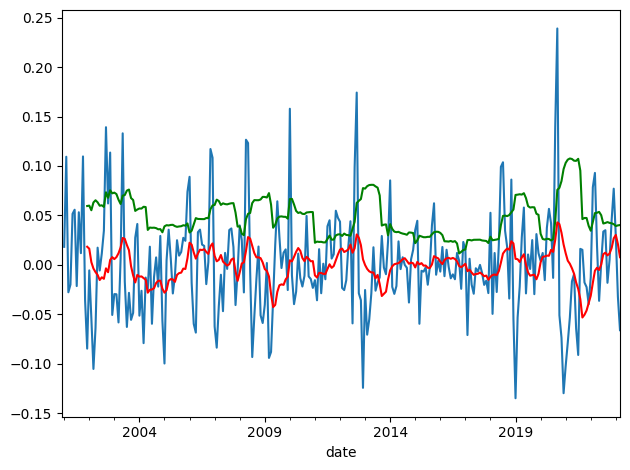

In [ ]:
#Diferenciação

#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
#desvio padrão
std_diff = df_diff.rolling(12).std()

#plotar a diferenciação
fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#extrair apenas os valores e retirar os valores NA
X = df_diff.VALVALOR.dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

In [ ]:
#Para encontrar os parâmetros de p, d, e q, usaremos as funções ACF (Autocorrelação) e PACF (Autocorrelação Parcial).
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

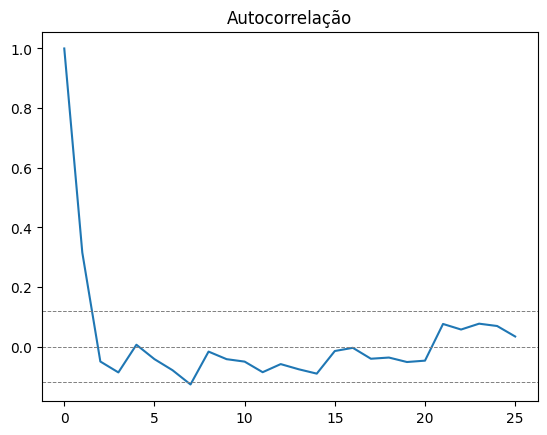

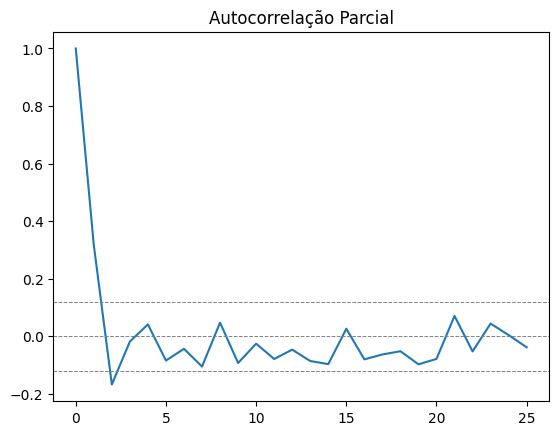

In [ ]:
# plotar ACF e PACF

plt.plot(lag_acf)
plt.axhline(y=-1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=-1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / (np.sqrt((len(df_diff) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação Parcial")
plt.show()

#Treinando e testando o modelo com ARIMA

In [ ]:
#Separando em treino e teste
df_train=df_log[:255]
df_test=df_log[255:]

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

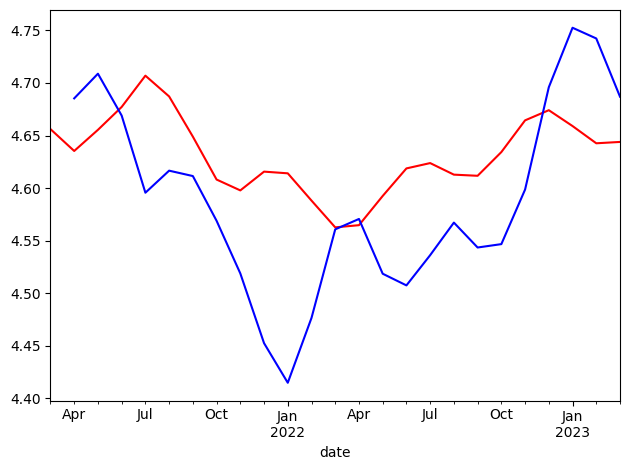

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(14,1,12)) #14,1,12
model_fit = model.fit()

predict = model_fit.predict(start="2021-03-01", end="2023-03-01")
fig, ax = plt.subplots()
predict.plot(ax=ax, legend=False, color='r')
df_test.plot(ax=ax, legend=False, color='b')
plt.tight_layout()

In [ ]:
#Separando em treino e teste (dados brutos)
df_train=df[:255]
df_test=df[255:]

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

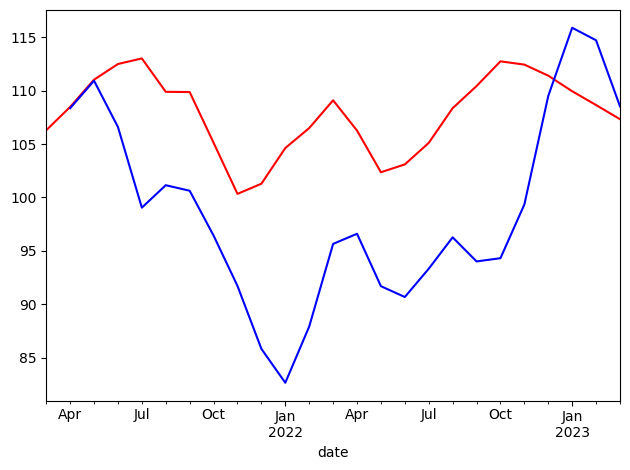

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(14,1,12)) #14,1,12
model_fit = model.fit()

predict = model_fit.predict(start="2021-03-01", end="2023-03-01")
fig, ax = plt.subplots()
predict.plot(ax=ax, legend=False, color='r')
df_test.plot(ax=ax, legend=False, color='b')
plt.tight_layout()

#Treinando e testando o modelo com PROPHET

In [ ]:
from prophet import Prophet 
from sklearn import metrics 
import prophet.plot
import prophet.diagnostics
from prophet.diagnostics import cross_validation

<Axes: xlabel='date'>

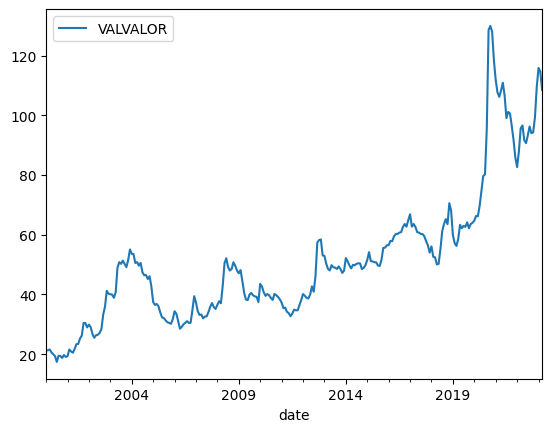

In [ ]:
df.sort_values("date", inplace=True)   # não vai servir
df.head()
df.plot()

In [ ]:
df_mensal = df.resample("m").sum() #definindo escala como mensal (agrupamento por meses)
df_mensal
df_mensal.reset_index(inplace=True)
df_mensal.index.name = ""
df_mensal = df_mensal.rename(columns={'VALVALOR': 'y'})
df_mensal = df_mensal.rename(columns={'date': "ds"})

In [ ]:
df_mensal

,ds,y
,,
0,2000-01-31,21.2200
1,2000-02-29,21.3100
2,2000-03-31,21.5600
3,2000-04-30,20.6000
4,2000-05-31,19.9500
...,...,...
274,2022-11-30,99.3432
275,2022-12-31,109.5028
276,2023-01-31,115.8807


#Separando, iniciando e comparando

In [ ]:
# os parâmetros estão em meses, então 1 ano = 12 meses e por aí vai. Agora precisamos separar treino e teste.

train_set = df_mensal[:255] 
test_set = df_mensal[255:]

In [ ]:
model_mensal = Prophet() # existem vários parâmetros, depende dos dados e da ideia do modelo. Como a ideia é ser algo introdutório é interessante deixar sem por enquanto.

In [ ]:
model_mensal.fit(train_set)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeqgtz88g/gs3wu26x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeqgtz88g/7laiomft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8507', 'data', 'file=/tmp/tmpeqgtz88g/gs3wu26x.json', 'init=/tmp/tmpeqgtz88g/7laiomft.json', 'output', 'file=/tmp/tmpeqgtz88g/prophet_modeldblhunxy/prophet_model-20230412013334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
y_pred = model_mensal.predict(test_set)

In [ ]:
y_pred.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-04-30,84.915958,69.674468,93.537260,84.915958,84.915958,-2.774701,-2.774701,-2.774701,-2.774701,-2.774701,-2.774701,0.0,0.0,0.0,82.141257
1,2021-05-31,85.422008,71.128860,95.321762,85.421795,85.422587,-1.985940,-1.985940,-1.985940,-1.985940,-1.985940,-1.985940,0.0,0.0,0.0,83.436068
2,2021-06-30,85.911734,72.675243,96.575935,85.901776,85.923083,-1.611719,-1.611719,-1.611719,-1.611719,-1.611719,-1.611719,0.0,0.0,0.0,84.300016
3,2021-07-31,86.417784,73.048979,96.234859,86.395866,86.443467,-2.239611,-2.239611,-2.239611,-2.239611,-2.239611,-2.239611,0.0,0.0,0.0,84.178174
4,2021-08-31,86.923835,73.334705,97.184841,86.884683,86.968560,-1.032424,-1.032424,-1.032424,-1.032424,-1.032424,-1.032424,0.0,0.0,0.0,85.891411


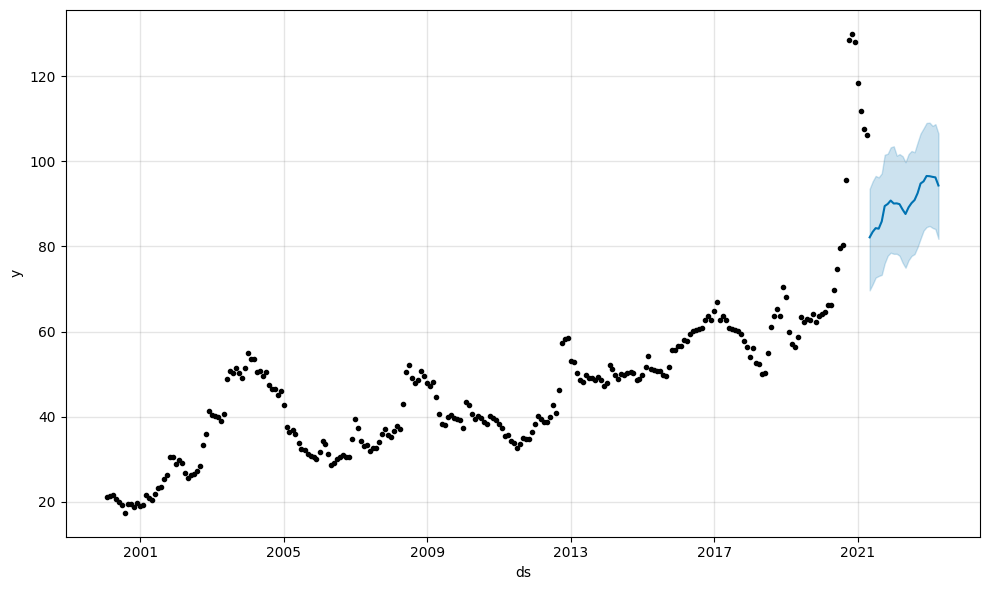

In [ ]:
model_mensal.plot(y_pred);

In [ ]:
y_pred["yhat"].values

array([82.14125694, 83.43606803, 84.30001576, 84.17817387, 85.89141102,
       89.49366105, 89.98668835, 90.78878751, 90.09318135, 90.12631371,
       89.94223345, 88.68201398, 87.6310681 , 89.18515949, 90.18867367,
       90.90649791, 92.52279901, 94.78533607, 95.31155811, 96.55881374,
       96.51040087, 96.35219418, 96.23575391, 94.32628888])

In [ ]:
print("MAE {}".format(metrics.mean_absolute_error(test_set["y"].values, y_pred["yhat"].values))) # erro absoluto medio 
print("RMSE {}".format(metrics.mean_squared_error(test_set["y"].values, y_pred["yhat"].values, squared=False))) # RMSE erro

MAE 9.717941518144016
RMSE 12.739717911483865


<Axes: xlabel='ds'>

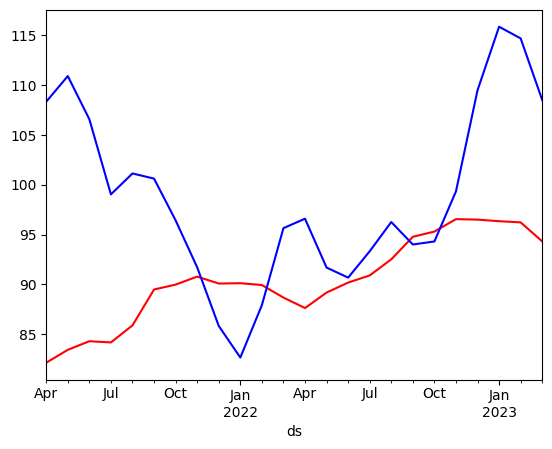

In [ ]:
y_pred.set_index("ds")["yhat"].plot(color="red")
test_set.set_index("ds")["y"].plot(color="blue")

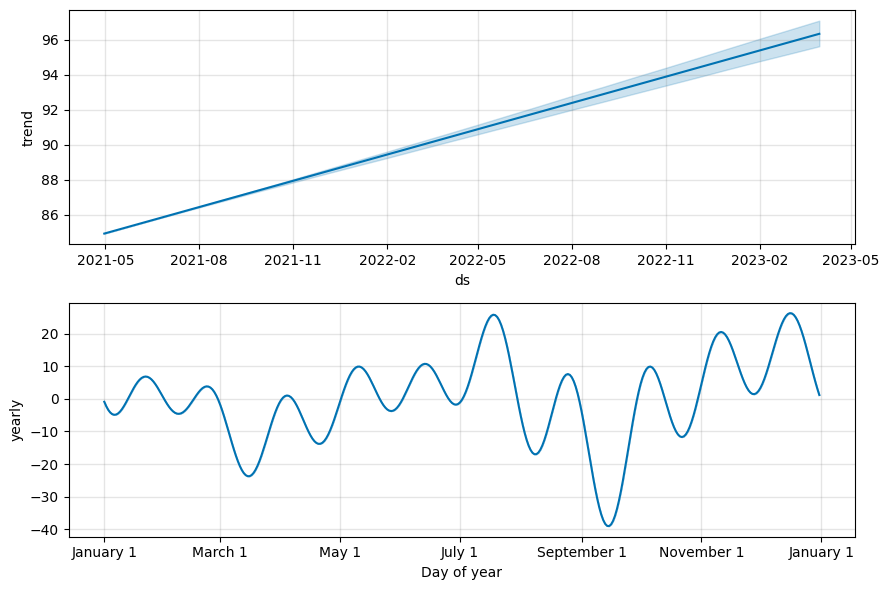

In [ ]:
components_mensal = model_mensal.plot_components(y_pred)
components_mensal;

# Random FOREST

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def mp(y_test, y_pred):
  d = pd.DataFrame({'mean_absolute_error': [round(mean_absolute_error(y_test, y_pred), 3)],
                    'mean_absolute_percentage_error': [round(mean_absolute_percentage_error(y_test, y_pred), 3)],
                    'r2_score': [round(r2_score(y_test, y_pred), 3)]})
  display(d)

  plt.figure(figsize = (16, 8))
  plt.plot(y_test, label = "y_test")
  plt.plot(y_pred, label = "y_pred")
  plt.legend()
  
  return d

<ipython-input-137-faeda31a0f15>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


,mean_absolute_error,mean_absolute_percentage_error,r2_score
0,1.034,0.017,0.996


,mean_absolute_error,mean_absolute_percentage_error,r2_score
0,1.034,0.017,0.996


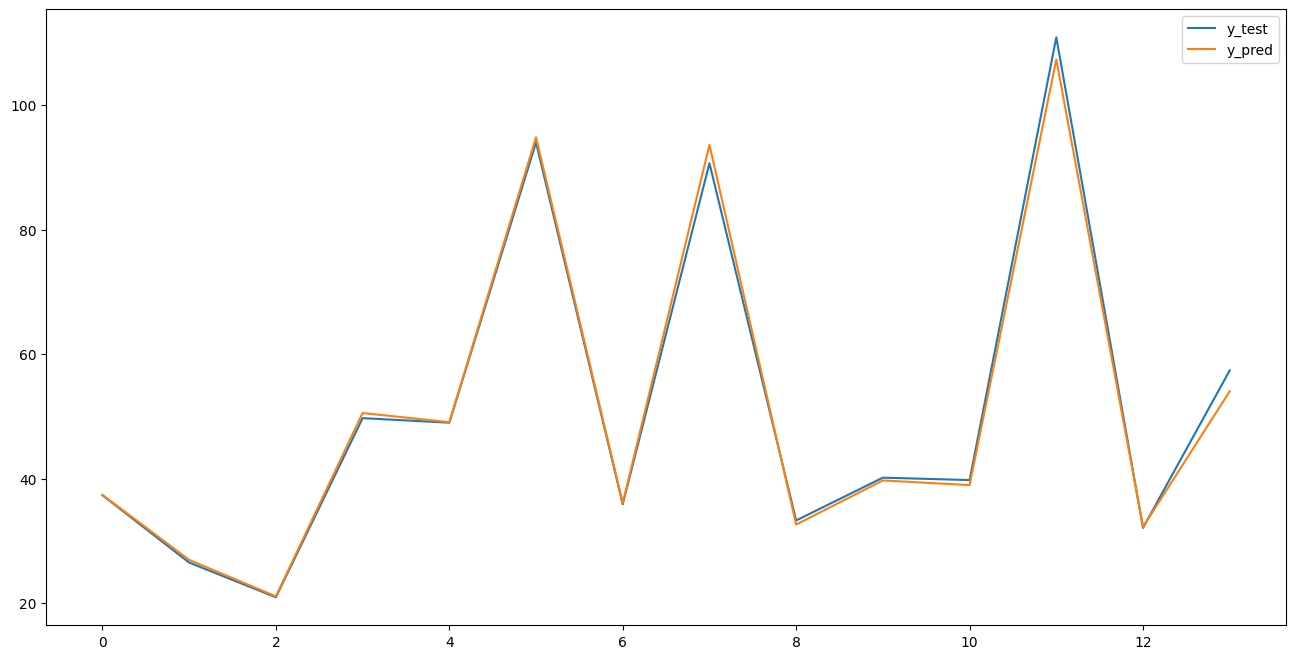

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

data = df["VALVALOR"].reset_index()

X = data["date"].values.reshape(-1, 1)
y = data["VALVALOR"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mp(y_test, y_pred)

# Conclusão

Dado a natureza dos dados coletados, isto é, arroz em uma variação de preço, a aplicabilidade de um modelo com boa acurácia se torna inviável. O motivo é justamente a escala de valor. Não existe um modelo que consiga extrapolar predições na escala de centavos. Pense em uma grande empresa, que compra toneladas e toneladas de arroz, cada 5, 10, 25 e 50 centavos possuem uma diferença absurda no valor total. Como próxima tentativa, tentaremos aplicar a ideia de tendência sem focar no valor, identificando baixas ou altas, seja em grãos ou em outros produtos/serviços.